In [1]:
import freud
import fresnel
import gsd.hoomd
import numpy as np
from PySide2 import QtCore
%gui qt
import fresnel.interact

In [2]:
with gsd.hoomd.open(name="restart.gsd", mode="rb") as gsd_file:
    snap = gsd_file[0]
box = freud.box.Box.from_box(snap.configuration.box)
images = snap.particles.image

unwraped_cords = box.unwrap(snap.particles.position, images)
N = snap.particles.N
print(box)

freud.box.Box(Lx=9.001799583435059, Ly=9.001799583435059, Lz=9.001799583435059, xy=0.0, xz=0.0, yz=0.0, is2D=False)


In [3]:
_ = snap.particles.typeid
colors = np.empty((N, 3))
# Color by typeid
colors[_ == 0] = [1, 0, 0]
colors[_ == 1] = [0, 1, 0]
colors[_ == 2] = [0, 0, 1]
# Box edges
def gen_box_cords(box):
    A = [0, box.Lx, 0]
    B = [0, 0, 0]
    C = [box.Lx, 0, 0]
    D = [box.Lx, box.Ly, 0]
    E = [0, box.Ly, box.Lz]
    F = [box.Lx, box.Ly, box.Lz]
    G = [box.Lx, 0, box.Lz]
    H = [0, 0, box.Lz]
    # Define all edges, then translate from cornor to center
    box_xyz = np.asarray(
        [
            [B, C],
            [B, A],
            [B, H],
            [C, G],
            [C, D],
            [G, F],
            [H, G],
            [A, D],
            [D, F],
            [E, F],
            [A, E],
            [E, H],
        ]
    ) - np.asarray([box.Lx / 2, box.Ly / 2, box.Lz / 2])
    return box_xyz


box_xyz = gen_box_cords(box)

In [4]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=N, radius=0.2)
geometry.position[:] = snap.particles.position  # unwraped_cords
geometry.material = fresnel.material.Material(
    color=fresnel.color.linear([0.25, 0.5, 0.9]), roughness=0.8
)
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)
# box
N_edges = box_xyz.shape[0]
box_edge = fresnel.geometry.Cylinder(scene, N=N_edges)
box_edge.material = fresnel.material.Material(
    color=fresnel.color.linear([0, 0, 0]), roughness=0
)
box_edge.points[:] = box_xyz
box_edge.radius[:] = [0.3] * N_edges
# bonds
N_bonds = snap.bonds.group.shape[0]
bonds = fresnel.geometry.Cylinder(scene, N=N_bonds)
bonds.material = fresnel.material.Material(
    color=fresnel.color.linear([0.5, 0.5, 0]), roughness=0.8
)
bonds.material.primitive_color_mix = 1.0
bonds.points[:] = np.stack(
    [
        snap.particles.position[snap.bonds.group[:, 0]],
        snap.particles.position[snap.bonds.group[:, 1]],
    ],
    axis=1,
)
# Color by bond typeid
bond_ids = snap.bonds.typeid
bond_colors = np.empty((N_bonds, 3))
bond_colors[bond_ids == 0] = [0, 1, 0]
bond_colors[bond_ids == 1] = [0, 0, 1]

bonds.color[:] = np.stack(
    [fresnel.color.linear(bond_colors), fresnel.color.linear(bond_colors)], axis=1
)
bonds.radius[:] = [0.1] * N_bonds


view = fresnel.interact.SceneView(scene)
# fresnel.preview(scene, aa_level=3)

In [5]:
view

In [3]:
# Okay all the cool stuff was just to verify that things were unwrapped correctly

['cpu', 'auto']


(array([  5.,  14.,  34.,  89., 124., 112.,  58.,  35.,  12.,   3.]),
 array([0.6447215, 0.7116059, 0.7784903, 0.8453747, 0.9122591, 0.9791435,
        1.0460279, 1.1129123, 1.1797967, 1.2466811, 1.3135655],
       dtype=float32),
 <a list of 10 Patch objects>)

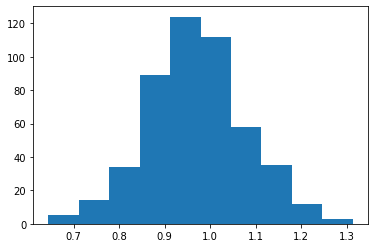

In [50]:
# all bonds bond
import matplotlib.pyplot as plt

%matplotlib inline
posn_A = snap.particles.position[snap.bonds.group[:, 0]]
posn_B = snap.particles.position[snap.bonds.group[:, 1]]
diff = posn_A - posn_B
bond_distance = np.linalg.norm(diff, axis=1)
plt.hist(bond_distance)

(array([ 2.,  3.,  4., 13., 14., 17., 11., 11.,  3.,  3.]),
 array([0.6447215, 0.6983996, 0.7520777, 0.8057558, 0.8594339, 0.913112 ,
        0.9667901, 1.0204682, 1.0741463, 1.1278243, 1.1815025],
       dtype=float32),
 <a list of 10 Patch objects>)

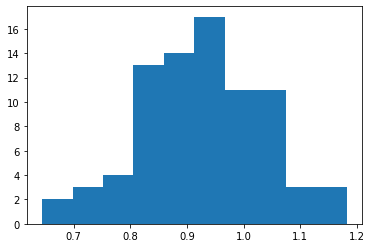

In [62]:
# B-B
posn_A_type_0 = snap.particles.position[snap.bonds.group[:, 0][snap.bonds.typeid == 0]]
posn_B_type_0 = snap.particles.position[snap.bonds.group[:, 1][snap.bonds.typeid == 0]]
diff_0 = posn_A_type_0 - posn_B_type_0
bond_distance_0 = np.linalg.norm(diff_0, axis=1)
plt.hist(bond_distance_0)

(array([  7.,  11.,  51.,  74., 102.,  78.,  41.,  28.,  10.,   3.]),
 array([0.689807  , 0.75218284, 0.8145587 , 0.8769345 , 0.9393104 ,
        1.0016862 , 1.0640621 , 1.1264379 , 1.1888138 , 1.2511896 ,
        1.3135655 ], dtype=float32),
 <a list of 10 Patch objects>)

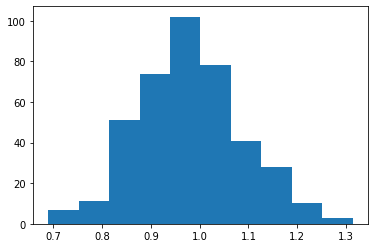

In [64]:
# C-C
posn_A_type_1 = snap.particles.position[snap.bonds.group[:, 0][snap.bonds.typeid == 1]]
posn_B_type_1 = snap.particles.position[snap.bonds.group[:, 1][snap.bonds.typeid == 1]]
diff_1 = posn_A_type_1 - posn_B_type_1
bond_distance_1 = np.linalg.norm(diff_1, axis=1)
plt.hist(bond_distance_1)

In [107]:
posn_A_type_0_angle = snap.particles.position[
    snap.angles.group[:, 0][snap.angles.typeid == 0]
]
posn_B_type_0_angle = snap.particles.position[
    snap.angles.group[:, 1][snap.angles.typeid == 0]
]
posn_C_type_0_angle = snap.particles.position[
    snap.angles.group[:, 2][snap.angles.typeid == 0]
]

B_type_0_A_type_0 = posn_A_type_0_angle - posn_B_type_0_angle
B_type_0_C_type_0 = posn_C_type_0_angle - posn_B_type_0_angle

angle_type_0 = np.dot(B_type_0_A_type_0, B_type_0_C_type_0) / (
    np.linalg.norm(B_type_0_A_type_0, axis=1) * np.linalg.norm(B_type_0_C_type_0, axis=1)
)
plt.hist(angle_type_0)

ValueError: shapes (324,3) and (324,3) not aligned: 3 (dim 1) != 324 (dim 0)

In [122]:
np.tensordot(B_type_0_A_type_0, B_type_0_C_type_0, axes=[1,1]).shape

(324, 324)

In [113]:
np.linalg.norm(B_type_0_A_type_0, axis=1).shape

(324,)

In [123]:
angle_type_0 = np.tensordot(B_type_0_A_type_0, B_type_0_C_type_0, axes=[1,1]) / (
    np.linalg.norm(B_type_0_A_type_0, axis=1) * np.linalg.norm(B_type_0_C_type_0, axis=1)
)